In [ ]:
# import tensoflow.keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import os
# from PIL import Image

In [ ]:
np.random.seed(1337)

#-- Cargar sólo las imágenes sin las etiquetas ---
(x_train, _), (x_test, _) = mnist.load_data()

# Normalizar
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Expandir canal (de (28,28) → (28,28,1))
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Redimensionar con interpolación bilineal a 32x32
x_train = tf.image.resize(x_train, [32, 32]).numpy()
x_test = tf.image.resize(x_test, [32, 32]).numpy()

print(x_train.shape, x_test.shape)  # → (60000, 32, 32, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 32, 32, 1) (10000, 32, 32, 1)


In [ ]:
input_img = layers.Input(shape=(32, 32, 1))

# --- Encoder ---
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)   # -> (16, 16, 16)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)   # -> (8, 8, 8)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # -> (4, 4, 8)

# --- Decoder usando Conv2DTranspose ---
x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation='relu', padding='same')(encoded)  # -> (8, 8, 8)
x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation='relu', padding='same')(x)        # -> (16, 16, 8)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same')(x)       # -> (32, 32, 16)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)                   # -> (32, 32, 1)

# --- Modelo final ---
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

print(autoencoder.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 8)        │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 8)      │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 16)     │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:

# Train the autoencoder
H = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.4969 - val_loss: 0.1914
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1773 - val_loss: 0.1489
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1457 - val_loss: 0.1371
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1363 - val_loss: 0.1321
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1322 - val_loss: 0.1291
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1291 - val_loss: 0.1266
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1271 - val_loss: 0.1250
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1255 - val_loss: 0.1240
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1244 - val_loss: 0.1229
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1236 - val_loss: 0.1224
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1229 - val_loss: 0.1218
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━

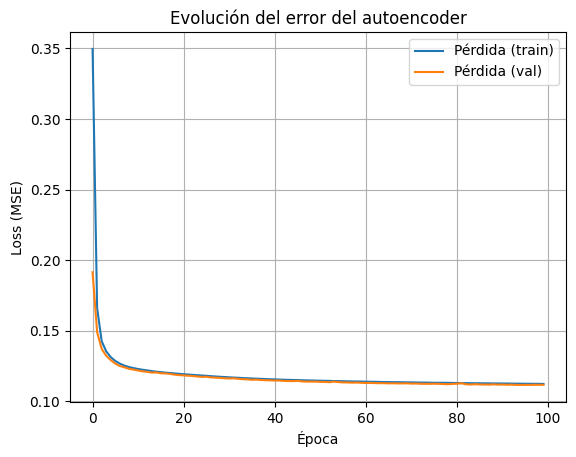

In [ ]:
import matplotlib.pyplot as plt

# Graficar la evolución del error
plt.plot(H.history['loss'], label='Pérdida (train)')
plt.plot(H.history['val_loss'], label='Pérdida (val)')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.title('Evolución del error del autoencoder')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluar_reconstruccion(autoencoder, datos, nombre=""):
    # Predicción del Autoencoder
    datos_reconstruidos = autoencoder.predict(datos)

    # Aplanar imágenes para comparar
    datos_flat = datos.reshape((datos.shape[0], -1))
    datos_reconstruidos_flat = datos_reconstruidos.reshape((datos_reconstruidos.shape[0], -1))

    # Cálculo de errores
    mse = mean_squared_error(datos_flat, datos_reconstruidos_flat)
    mae = mean_absolute_error(datos_flat, datos_reconstruidos_flat)

    print(f"[{nombre}] MSE: {mse:.6f} | MAE: {mae:.6f}")
    #return mse, mae

# Evaluar en entrenamiento
evaluar_reconstruccion(autoencoder, x_train, nombre="Entrenamiento")

# Evaluar en testeo
evaluar_reconstruccion(autoencoder, x_test, nombre="Testeo")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
[Entrenamiento] MSE: 0.005536 | MAE: 0.026966
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Testeo] MSE: 0.005396 | MAE: 0.026669


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


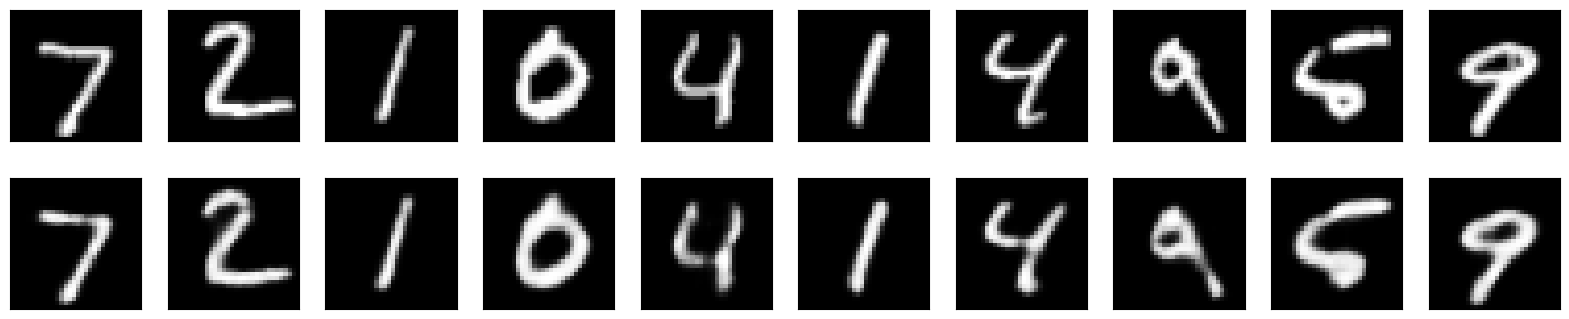

In [ ]:
# Predicción del Autoencoder
x_decoded = autoencoder.predict(x_test)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_decoded[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()